# About the dataset
It is a public set of comments collected for spam research. It has five datasets composed by 1,956 real messages extracted from five videos that were among the 10 most viewed on the collection period.

In [208]:
import html
import os
import nltk
import string
import emoji

import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from wordcloud import WordCloud
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
from scipy.stats import wilcoxon

# Needed by nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("words")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /home/kalex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kalex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kalex/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /home/kalex/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kalex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [209]:
# Import the dataset
dataset_dir = "./dataset/"

data = []
for f in os.listdir(dataset_dir):
    data.append(pd.read_csv(dataset_dir + f))

# Ignore index so that we get rows indexed correctly from 0 to 1955
df = pd.concat(data, ignore_index=True)
df

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
...,...,...,...,...,...
1951,_2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0
1952,_2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0
1953,_2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs,jeffrey jules,2013-07-13T12:09:31.188000,wow,0
1954,_2viQ_Qnc6_yBt8UGMWyg3vh0PulTqcqyQtdE7d4Fl0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0


In [210]:
df.tail(10)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
1946,_2viQ_Qnc69MEEHHJxZ427KX8MlljJPnUC2YBbvbWwY,ThirdDegr3e,2013-07-13T20:48:06.033000,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,1
1947,_2viQ_Qnc6_RKHVetk9kLzx8ZC62_J7y73FWFSBTe8Q,ThirdDegr3e,2013-07-13T20:47:40.793000,**CHECK OUT MY NEW MIXTAPE**** **CHECK OUT MY ...,1
1948,_2viQ_Qnc68TufyXKiTwky80ewSPbhRiD5XFHrJH9lg,Ysobel Schofield,2013-07-13T20:17:25.181000,Waka waka she rules,0
1949,_2viQ_Qnc689m-WiwOwvrQU7LvkLAgspnfXL8ovE0ME,TheHotChocolate,2013-07-13T18:26:37.017000,she is sooooo beautiful!,0
1950,_2viQ_Qnc6_1Hq9MGlefkBIszt9rYD3S_CozADvMhQ4,Dinova Sharon,2013-07-13T14:44:00.700000,well done shakira,0
1951,_2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,0
1952,_2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,0
1953,_2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs,jeffrey jules,2013-07-13T12:09:31.188000,wow,0
1954,_2viQ_Qnc6_yBt8UGMWyg3vh0PulTqcqyQtdE7d4Fl0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,0
1955,_2viQ_Qnc685RPw1aSa1tfrIuHXRvAQ2rPT9R06KTqA,Latin Bosch,2013-07-12T22:33:27.916000,Shakira is the best dancer,0


In [211]:
# Only DATE contains null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   CLASS       1956 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 76.5+ KB


In [212]:
# Check descriptive statistics
# Not much to see here as we are working with NLP
df.describe(include="all")

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
count,1956,1956,1711,1956,1956.000000
unique,1953,1792,1709,1760,NaN
top,_2viQ_Qnc68fX3dYsfYuM-m4ELMJvxOQBmBOFHqGOk0,M.E.S,2013-10-05T00:57:25.078000,Check out this video on YouTube:﻿,NaN
freq,2,8,2,97,NaN
mean,NaN,NaN,NaN,NaN,0.513804
std,NaN,NaN,NaN,NaN,0.499937
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,1.000000


In [213]:
# Check for null values
# Confirms that only DATE contains some null values
df.isna().sum()

COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
CLASS           0
dtype: int64

In [214]:
# Check if the dataset is balanced
# Not perfectly balanced, but still balanced enough to consider it balanced
df.CLASS.value_counts()

1    1005
0     951
Name: CLASS, dtype: int64

In [215]:
# Remove duplicates
# 3 rows have been removed, which doesn't affect balancing at all
df.drop_duplicates(inplace=True)

# TODO: remove author

# We can safely drop features we don't need for analysis
# Keep AUTHOR, may be used to identify a particular AUTHOR that spams
# On the other hand, COMMENT_ID and DATE are not relevant
to_drop = ["COMMENT_ID", "DATE"]
df.drop(labels=to_drop, axis=1, inplace=True)
df

,AUTHOR,CONTENT,CLASS
0,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1
1,adam riyati,Hey guys check out my new channel and our firs...,1
2,Evgeny Murashkin,just for test I have to say murdev.com,1
3,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .﻿,1
...,...,...,...
1951,Katie Mettam,I love this song because we sing it at Camp al...,0
1952,Sabina Pearson-Smith,I love this song for two reasons: 1.it is abou...,0
1953,jeffrey jules,wow,0
1954,Aishlin Maciel,Shakira u are so wiredo,0


In [216]:
# Comments contain HTML entities, so we decode them

df.CONTENT = df.CONTENT.apply(html.unescape)
df

,AUTHOR,CONTENT,CLASS
0,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1
1,adam riyati,Hey guys check out my new channel and our firs...,1
2,Evgeny Murashkin,just for test I have to say murdev.com,1
3,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .﻿,1
...,...,...,...
1951,Katie Mettam,I love this song because we sing it at Camp al...,0
1952,Sabina Pearson-Smith,I love this song for two reasons: 1.it is abou...,0
1953,jeffrey jules,wow,0
1954,Aishlin Maciel,Shakira u are so wiredo,0


In [217]:
# Comments contain some <br /> tags
# Replace then with newlines
df.CONTENT = df.CONTENT.apply(lambda s: s.replace("<br />", "\n"))

In [218]:
# Check if a given comment contains a link, which may indicate spam (e.g. links to other youtube channels)
def contains_link(s):
    return (
        1
        if any(
            fragment in s.lower()
            for fragment in ["http://", "https://", "www.", ".com"]
        )
        else 0
    )


def contains_yt_link(s):
    return 1 if "www.youtube.com" in s.lower() or "watch?v=" in s.lower() else 0


# Check if a given comment contains non-ASCII characters
def contains_non_ascii_chars(s):
    return 1 if not s.isascii() else 0


# Additionally, get the number of chars, words and sentences
def count_words(s):
    return len(nltk.word_tokenize(s))


def count_sentences(s):
    return len(nltk.sent_tokenize(s))


# Spam comments may use a lot of upper cases
def count_uppercase(s):
    return sum(1 for c in s if c.isupper())


# Most comments contain non-ASCII characters
# Recognize how many are emojis, which may be useful to tell apart ham/spam
def count_emojis(s):
    return emoji.emoji_count(s)


# Add everything to the dataset
df["HAS_LINKS"] = df.CONTENT.apply(contains_link)
df["HAS_YT_LINKS"] = df.CONTENT.apply(contains_yt_link)
df["HAS_NON_ASCII_CHARS"] = df.CONTENT.apply(contains_non_ascii_chars)
df["CHAR_COUNT"] = df.CONTENT.apply(len)
df["WORD_COUNT"] = df.CONTENT.apply(count_words)
df["SENTENCE_COUNT"] = df.CONTENT.apply(count_sentences)
df["UPPERCASE_COUNT"] = df.CONTENT.apply(count_uppercase)
df["EMOJI_COUNT"] = df.CONTENT.apply(count_emojis)

df

,AUTHOR,CONTENT,CLASS,HAS_LINKS,HAS_YT_LINKS,HAS_NON_ASCII_CHARS,CHAR_COUNT,WORD_COUNT,SENTENCE_COUNT,UPPERCASE_COUNT,EMOJI_COUNT
0,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1,0,0,0,56,13,1,1,0
1,adam riyati,Hey guys check out my new channel and our firs...,1,0,0,0,166,40,3,20,0
2,Evgeny Murashkin,just for test I have to say murdev.com,1,1,0,0,38,8,1,1,0
3,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,0,0,1,48,11,1,0,0
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .﻿,1,0,1,1,39,7,1,6,0
...,...,...,...,...,...,...,...,...,...,...,...
1951,Katie Mettam,I love this song because we sing it at Camp al...,0,0,0,0,58,15,2,2,0
1952,Sabina Pearson-Smith,I love this song for two reasons: 1.it is abou...,0,0,0,0,93,19,1,3,0
1953,jeffrey jules,wow,0,0,0,0,3,1,1,0,0
1954,Aishlin Maciel,Shakira u are so wiredo,0,0,0,0,23,5,1,1,0


In [219]:
df.describe(include="all")

,AUTHOR,CONTENT,CLASS,HAS_LINKS,HAS_YT_LINKS,HAS_NON_ASCII_CHARS,CHAR_COUNT,WORD_COUNT,SENTENCE_COUNT,UPPERCASE_COUNT,EMOJI_COUNT
count,1953,1953,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.00000
unique,1792,1760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M.E.S,Check out this video on YouTube:﻿,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,8,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.513569,0.125960,0.011777,0.809012,92.958525,19.865847,1.825397,9.151050,0.27701
std,NaN,NaN,0.499944,0.331889,0.107907,0.393180,125.244911,30.528380,2.111330,26.021177,3.59439
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.00000
25%,NaN,NaN,0.000000,0.000000,0.000000,1.000000,29.000000,6.000000,1.000000,1.000000,0.00000
50%,NaN,NaN,1.000000,0.000000,0.000000,1.000000,47.000000,10.000000,1.000000,2.000000,0.00000
75%,NaN,NaN,1.000000,0.000000,0.000000,1.000000,95.000000,20.000000,2.000000,6.000000,0.00000


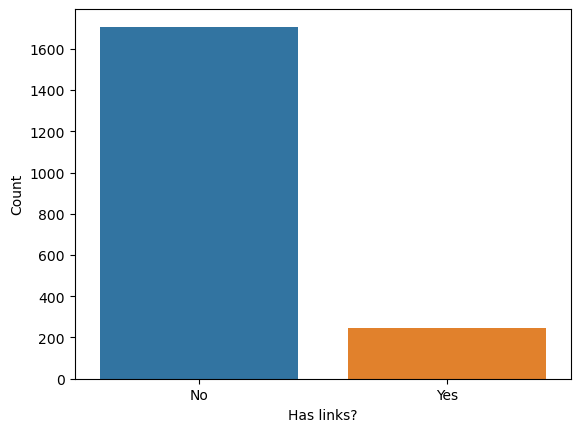

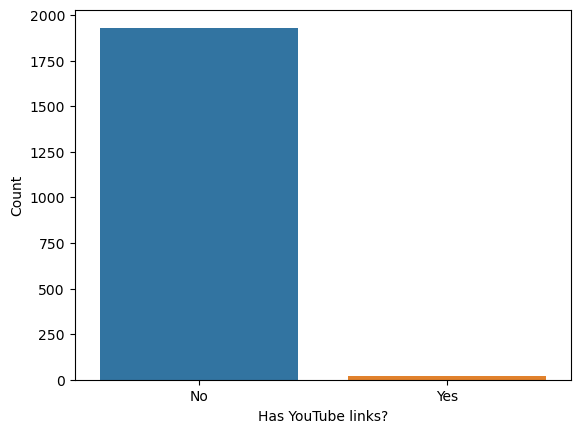

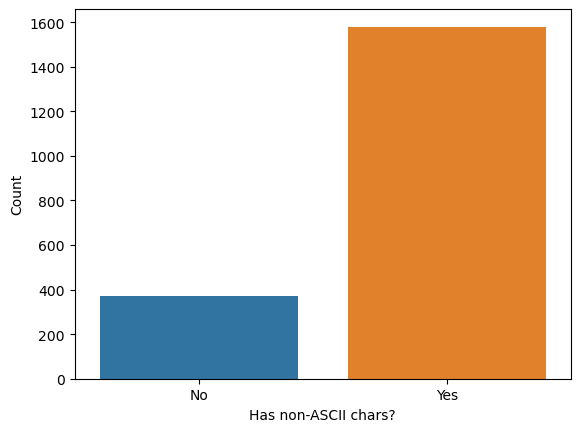

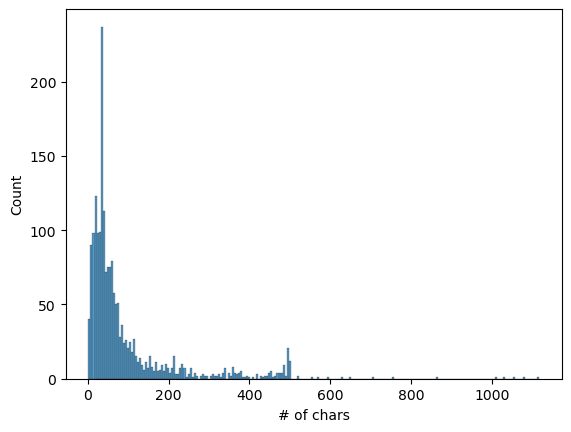

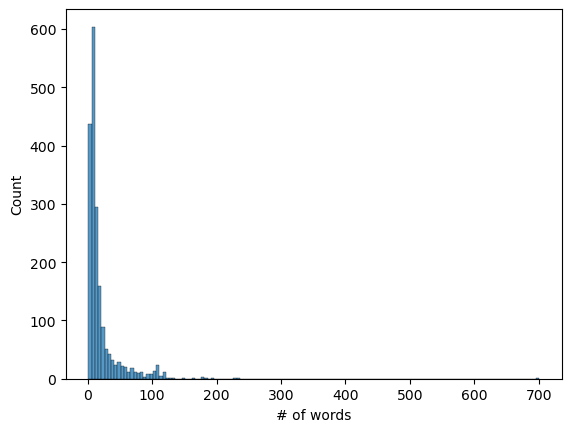

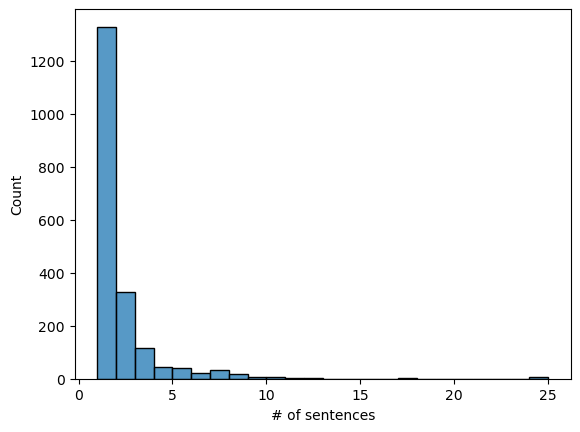

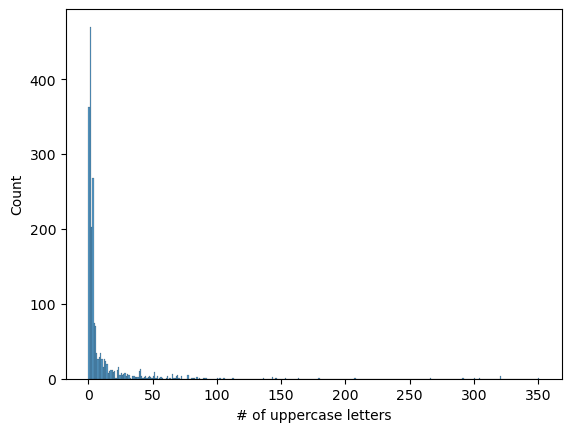

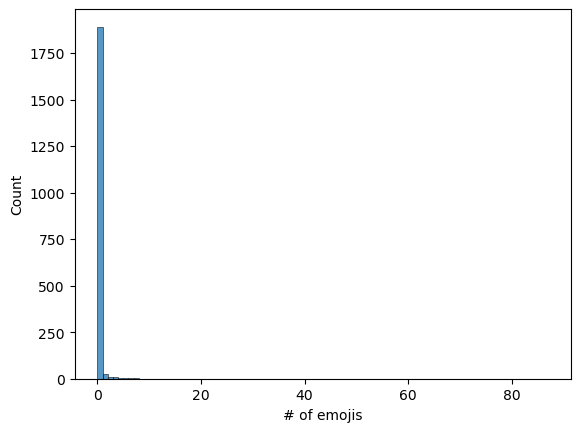

In [220]:
# Plot barplot/histogram of extracted features

copy = df.copy()

g = sns.countplot(
    x=copy.HAS_LINKS,
)
g.set_xticklabels(["No", "Yes"])
g.set_xlabel("Has links?")
g.set_ylabel("Count")
plt.savefig("figures/links_countplot")
plt.show()

g = sns.countplot(x=copy.HAS_YT_LINKS)
g.set_xticklabels(["No", "Yes"])
g.set_xlabel("Has YouTube links?")
g.set_ylabel("Count")
plt.savefig("figures/yt_links_countplot")
plt.show()

g = sns.countplot(x=copy.HAS_NON_ASCII_CHARS)
g.set_xticklabels(["No", "Yes"])
g.set_xlabel("Has non-ASCII chars?")
g.set_ylabel("Count")
plt.savefig("figures/non_ascii_countplot")
plt.show()

g = sns.histplot(x=copy.CHAR_COUNT, binwidth=5)
g.set_xlabel("# of chars")
g.set_ylabel("Count")
plt.savefig("figures/chars_histplot")
plt.show()

g = sns.histplot(x=copy.WORD_COUNT, binwidth=5)
g.set_xlabel("# of words")
g.set_ylabel("Count")
plt.savefig("figures/words_histplot")
plt.show()

g = sns.histplot(x=copy.SENTENCE_COUNT, binwidth=1)
g.set_xlabel("# of sentences")
g.set_ylabel("Count")
plt.savefig("figures/sentences_histplot")
plt.show()

g = sns.histplot(x=copy.UPPERCASE_COUNT, binwidth=1)
g.set_xlabel("# of uppercase letters")
g.set_ylabel("Count")
plt.savefig("figures/uppercases_histplot")
plt.show()

g = sns.histplot(x=copy.EMOJI_COUNT, binwidth=1)
g.set_xlabel("# of emojis")
g.set_ylabel("Count")
plt.savefig("figures/emojis_histplot")
plt.show()

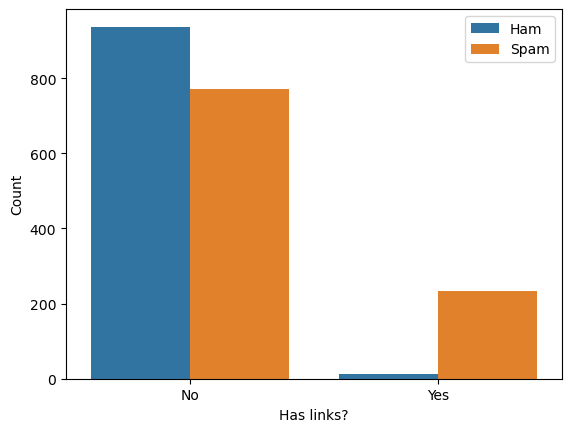

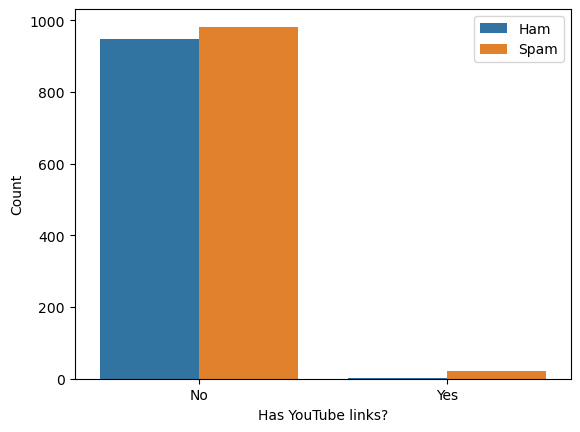

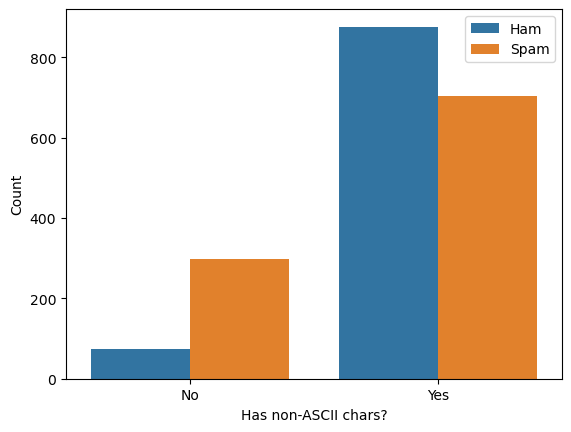

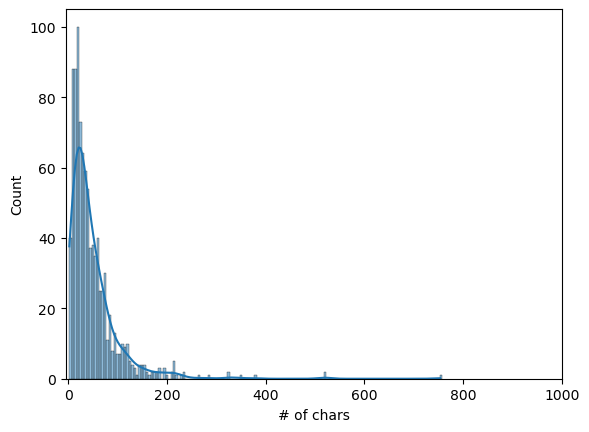

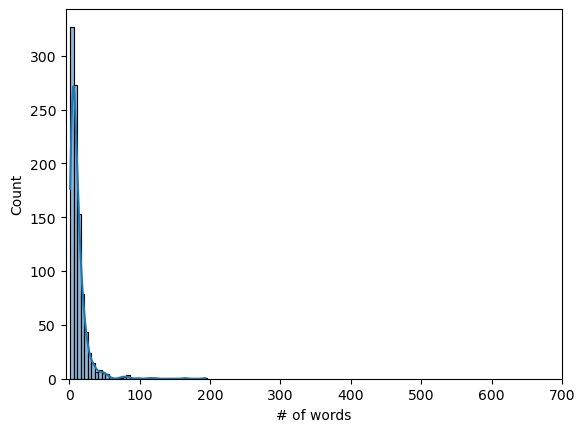

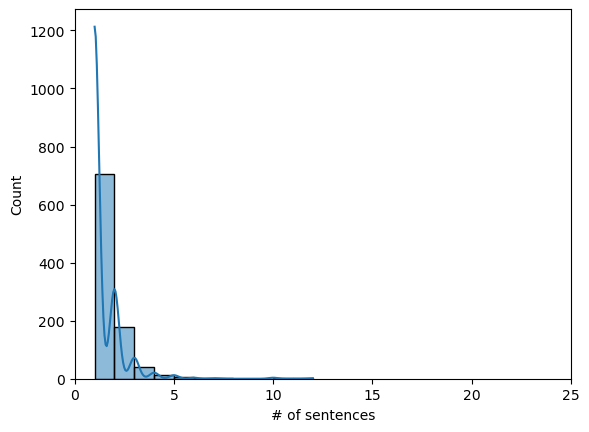

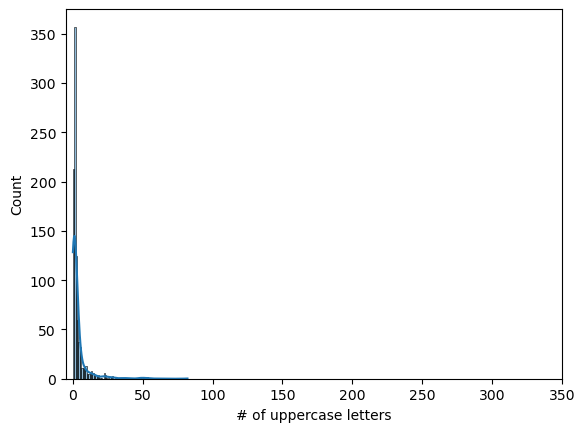

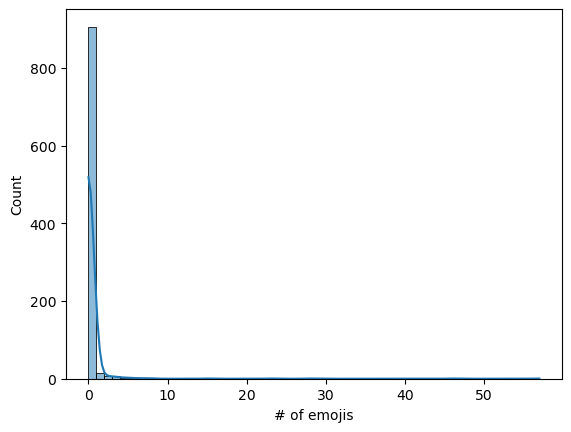

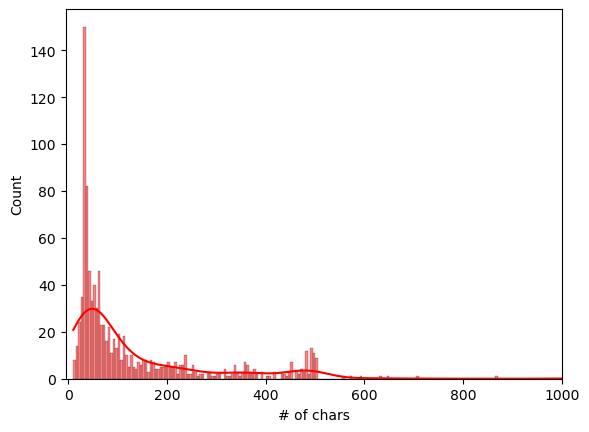

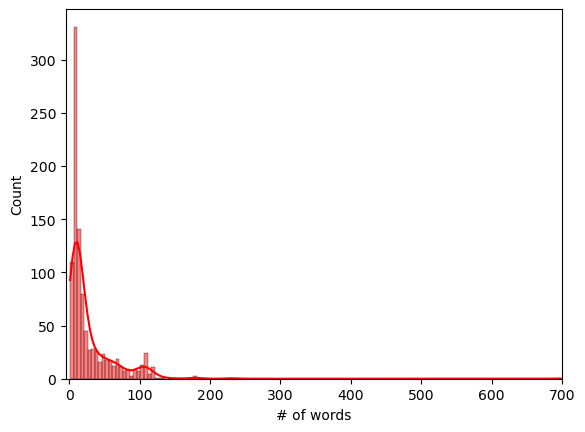

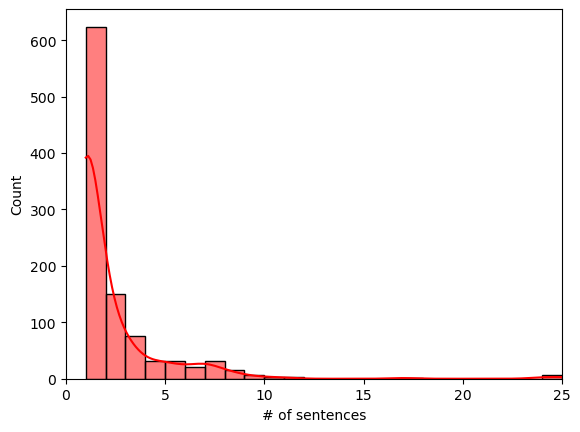

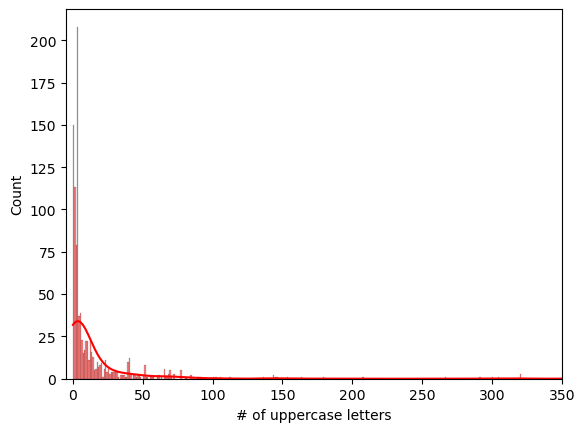

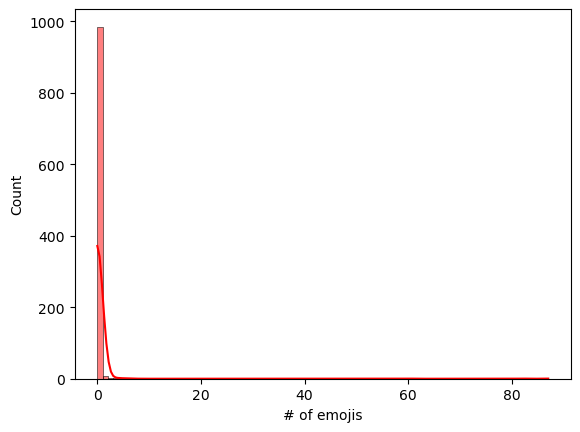

In [221]:
# Plot barplot/histogram of extracted features divided per class

copy = df.copy()

g = sns.countplot(x=copy.HAS_LINKS, hue=copy.CLASS)
g.set_xticklabels(["No", "Yes"])
g.legend(labels=["Ham", "Spam"])
g.set_xlabel("Has links?")
g.set_ylabel("Count")
plt.savefig("figures/links_countplot_class")
plt.show()

g = sns.countplot(x=copy.HAS_YT_LINKS, hue=copy.CLASS)
g.set_xticklabels(["No", "Yes"])
g.legend(labels=["Ham", "Spam"])
g.set_xlabel("Has YouTube links?")
g.set_ylabel("Count")
plt.savefig("figures/yt_links_countplot_class")
plt.show()

g = sns.countplot(x=copy.HAS_NON_ASCII_CHARS, hue=copy.CLASS)
g.set_xticklabels(["No", "Yes"])
g.legend(labels=["Ham", "Spam"])
g.set_xlabel("Has non-ASCII chars?")
g.set_ylabel("Count")
plt.savefig("figures/non_ascii_countplot_class")
plt.show()

# Histplots (class == 0)

g = sns.histplot(x=copy[copy.CLASS == 0].CHAR_COUNT, binwidth=5, kde=True)
g.set_xlim(-5, 1000)
g.set_xlabel("# of chars")
g.set_ylabel("Count")
plt.savefig("figures/chars_histplot_class_0")
plt.show()

g = sns.histplot(x=copy[copy.CLASS == 0].WORD_COUNT, binwidth=5, kde=True)
g.set_xlim(-5, 700)
g.set_xlabel("# of words")
g.set_ylabel("Count")
plt.savefig("figures/words_histplot_class_0")
plt.show()

g = sns.histplot(x=copy[copy.CLASS == 0].SENTENCE_COUNT, binwidth=1, kde=True)
g.set_xlim(0, 25)
g.set_xlabel("# of sentences")
g.set_ylabel("Count")
plt.savefig("figures/sentences_histplot_class_0")
plt.show()

g = sns.histplot(x=copy[copy.CLASS == 0].UPPERCASE_COUNT, binwidth=1, kde=True)
g.set_xlim(-5, 350)
g.set_xlabel("# of uppercase letters")
g.set_ylabel("Count")
plt.savefig("figures/uppercases_histplot_class_0")
plt.show()

g = sns.histplot(x=copy[copy.CLASS == 0].EMOJI_COUNT, binwidth=1, kde=True)
g.set_xlabel("# of emojis")
g.set_ylabel("Count")
plt.savefig("figures/emojis_histplot_class_0")
plt.show()


# Histplots (class == 1)

g = sns.histplot(x=copy[copy.CLASS == 1].CHAR_COUNT, binwidth=5, kde=True, color="red")
g.set_xlim(-5, 1000)
g.set_xlabel("# of chars")
g.set_ylabel("Count")
plt.savefig("figures/chars_histplot_class_1")
plt.show()

g = sns.histplot(x=copy[copy.CLASS == 1].WORD_COUNT, binwidth=5, kde=True, color="red")
g.set_xlim(-5, 700)
g.set_xlabel("# of words")
g.set_ylabel("Count")
plt.savefig("figures/words_histplot_class_1")
plt.show()

g = sns.histplot(
    x=copy[copy.CLASS == 1].SENTENCE_COUNT, binwidth=1, kde=True, color="red"
)
g.set_xlim(0, 25)
g.set_xlabel("# of sentences")
g.set_ylabel("Count")
plt.savefig("figures/sentences_histplot_class_1")
plt.show()

g = sns.histplot(
    x=copy[copy.CLASS == 1].UPPERCASE_COUNT, binwidth=1, kde=True, color="red"
)
g.set_xlim(-5, 350)
g.set_xlabel("# of uppercase letters")
g.set_ylabel("Count")
plt.savefig("figures/uppercases_histplot_class_1")
plt.show()

g = sns.histplot(x=copy[copy.CLASS == 1].EMOJI_COUNT, binwidth=1, kde=True, color="red")
g.set_xlabel("# of emojis")
g.set_ylabel("Count")
plt.savefig("figures/emojis_histplot_class_1")
plt.show()

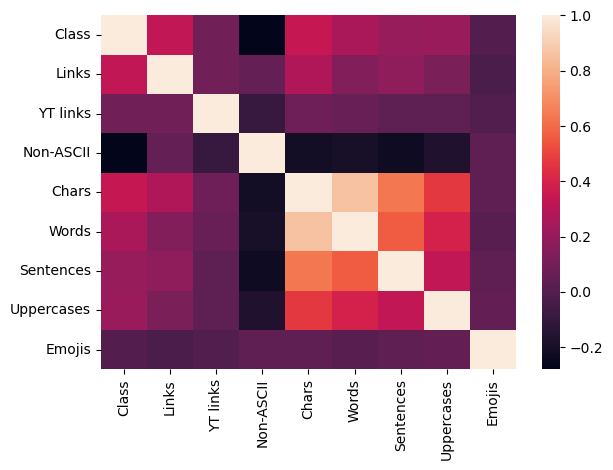

In [222]:
# See if there are correlated features (e.g. HAS_LINKS and CLASS)
# Of course, CHAR_COUNT, WORD_COUNT and SENTENCE_COUNT are (positively) correlated
copy = df.copy()
copy.rename(
    columns={
        "CLASS": "Class",
        "HAS_LINKS": "Links",
        "HAS_YT_LINKS": "YT links",
        "HAS_NON_ASCII_CHARS": "Non-ASCII",
        "CHAR_COUNT": "Chars",
        "WORD_COUNT": "Words",
        "SENTENCE_COUNT": "Sentences",
        "UPPERCASE_COUNT": "Uppercases",
        "EMOJI_COUNT": "Emojis",
    },
    inplace=True,
)
corr = copy.corr(numeric_only=True)

ax = sns.heatmap(corr)
plt.tight_layout()
plt.savefig("figures/heatmap")

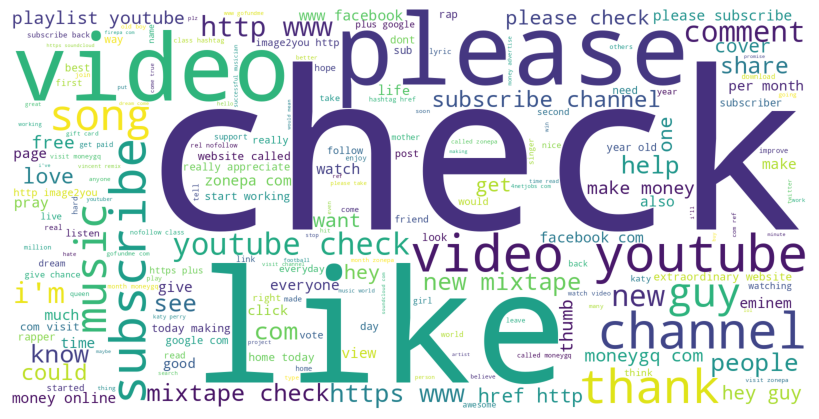

In [230]:
# Show the word cloud for both spam and ham messages
stopwords = nltk.corpus.stopwords.words("english")

spam_comments = " ".join(x.lower() for x in df[df.CLASS == 1].CONTENT)

wordcloud = WordCloud(
    width=1600,
    height=800,
    normalize_plurals=True,
    min_word_length=3,
    stopwords=stopwords,
    background_color="white",
).generate(spam_comments)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("figures/spam_wordcloud")

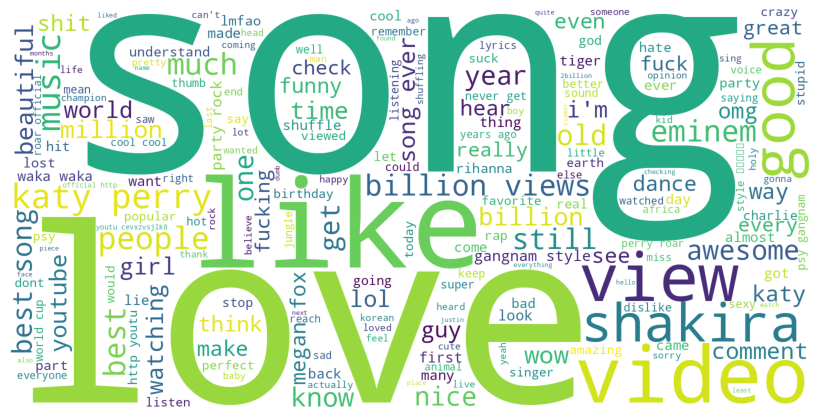

In [232]:
# Show the word cloud for both spam and ham messages
stopwords = nltk.corpus.stopwords.words("english")

ham_comments = " ".join(x.lower() for x in df[df.CLASS == 0].CONTENT)

wordcloud = WordCloud(
    width=1600,
    height=800,
    normalize_plurals=True,
    min_word_length=3,
    stopwords=stopwords,
    background_color="white",
).generate(ham_comments)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("figures/ham_wordcloud")

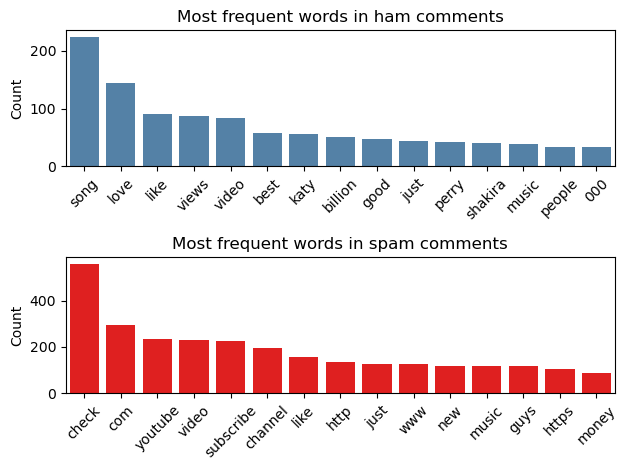

In [225]:
def compute_freq(comments):
    cv = CountVectorizer(stop_words="english").fit(comments)
    bag_of_words = cv.transform(comments)
    words_sum = bag_of_words.sum(axis=0)
    words_freq = sorted(
        ((word, words_sum[0, x]) for word, x in cv.vocabulary_.items()),
        key=lambda y: y[1],
        reverse=True,
    )
    return words_freq


ham_df = pd.DataFrame(
    compute_freq(df[df.CLASS == 0].CONTENT)[:15], columns=["word", "count"]
)
spam_df = pd.DataFrame(
    compute_freq(df[df.CLASS == 1].CONTENT)[:15], columns=["word", "count"]
)

fig, ax = plt.subplots(2, 1)
g = sns.barplot(x="word", y="count", data=ham_df, ax=ax[0], color="steelblue")
g.set_title("Most frequent words in ham comments")
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_xlabel("")
g.set_ylabel("Count")

g = sns.barplot(x="word", y="count", data=spam_df, ax=ax[1], color="red")
g.set_title("Most frequent words in spam comments")
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_xlabel("")
g.set_ylabel("Count")

plt.tight_layout()
plt.savefig("figures/word_frequencies")

# Classification

In [226]:
vect = TfidfVectorizer(stop_words=stopwords)
analyzer = vect.build_analyzer()

snowball_stemmer = nltk.SnowballStemmer("english")
porter_stemmer = nltk.PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()


def snowball(x):
    return [" ".join([snowball_stemmer.stem(w) for w in analyzer(doc)]) for doc in x]


def porter(x):
    return [" ".join([porter_stemmer.stem(w) for w in analyzer(doc)]) for doc in x]


def lemmatisation(x):
    return [" ".join([lemmatizer.lemmatize(w) for w in analyzer(doc)]) for doc in x]


print(df.CONTENT[1])
print(snowball(df.CONTENT))
print(porter(df.CONTENT))
print(lemmatisation(df.CONTENT))

Hey guys check out my new channel and our first vid THIS IS US THE  MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment  and please subscribe!!!!
['huh anyway check tube channel kobyoshi02', 'hey guy check new channel first vid us monkey monkey white shirt pleas leav like comment pleas subscrib', 'test say murdev com', 'shake sexi ass channel enjoy', 'watch vtarggvgtwq check', 'hey check new websit site kid stuff kidsmediausa com', 'subscrib channel', 'turn mute soon came want check view', 'check channel funni video', 'check channel tell next', 'hey subscrib', 'start read stop subscrib within one day entir famili die want stay aliv subscrib right', 'https twitter com gbphotographygb', 'subscrib like comment', 'pleas like https premium easypromosapp com votem 19924 616375350', 'hello like game art video scientif experi tutori lyric video much much pleas check channel subscrib start soon hope abl cover expect also check got far', 'check view', 'http www ebay com itm 

In [228]:
classifiers = [
    ("SVC", SVC()),
    ("Naive Bayes", MultinomialNB()),
    ("Decision tree", DecisionTreeClassifier()),
    ("Random forest", RandomForestClassifier()),
]

preprocessors = [
    ("Snowball stemmer", snowball),
    ("Porter stemmer", porter),
    ("Lemmatisation", lemmatisation),
]

folds = 10


def classify(data, preprocessors, classifiers):
    table = [
        ["Preprocessor"],
        ["Classifier"],
        ["Confusion matrix"],
        ["Accuracy"],
        ["Precision"],
        ["Recall"],
        ["F1 score"],
    ]
    results = []

    for pname, preprocessor in preprocessors:
        for name, classifier in classifiers:
            x = preprocessor(data.copy().CONTENT)
            y = data.CLASS
            pipe = Pipeline(
                [
                    (
                        "count vectorizer",
                        CountVectorizer(lowercase=True, stop_words="english"),
                    ),
                    (name, classifier),
                ]
            )

            kfold = KFold(folds, shuffle=True, random_state=0x1337)

            predictions = cross_val_predict(pipe, x, y, cv=kfold)
            cmatrix = confusion_matrix(y, predictions)
            accuracy = cross_val_score(pipe, x, y, cv=kfold, scoring="accuracy")
            precision = cross_val_score(pipe, x, y, cv=kfold, scoring="precision_macro")
            recall = cross_val_score(pipe, x, y, cv=kfold, scoring="recall_macro")
            F1 = cross_val_score(pipe, x, y, cv=kfold, scoring="f1_macro")

            table[0] += [pname, ""]
            table[1] += [name, ""]
            table[2] += [str(cmatrix), ""]
            table[3] += [round(accuracy.mean(), 3), ""]
            table[4] += [round(precision.mean(), 3), ""]
            table[5] += [round(recall.mean(), 3), ""]
            table[6] += [round(F1.mean(), 3), ""]
            
            results.append((pname, name, accuracy))
    
    print(tabulate(table))
    return results


results = classify(df.copy(), preprocessors, classifiers)

----------------  ----------------    ----------------    ----------------    ----------------    --------------    --------------    --------------    --------------    -------------    -------------    -------------    -------------
Preprocessor      Snowball stemmer    Snowball stemmer    Snowball stemmer    Snowball stemmer    Porter stemmer    Porter stemmer    Porter stemmer    Porter stemmer    Lemmatisation    Lemmatisation    Lemmatisation    Lemmatisation
Classifier        SVC                 Naive Bayes         Decision tree       Random forest       SVC               Naive Bayes       Decision tree     Random forest     SVC              Naive Bayes      Decision tree    Random forest
Confusion matrix  [[917  33]          [[828 122]          [[918  32]          [[928  22]          [[918  32]        [[828 122]        [[920  30]        [[927  23]        [[919  31]       [[829 121]       [[911  39]       [[926  24]
                   [ 68 935]]          [ 57 946]]          [ 47

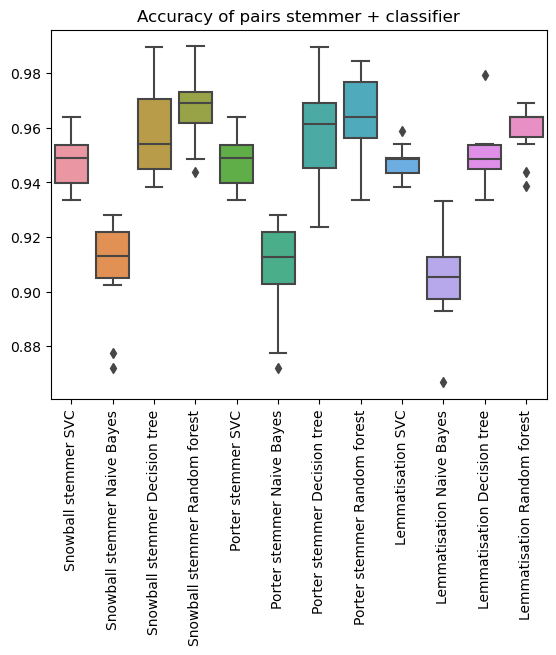

In [227]:
g = sns.boxplot([x[2] for x in results])
g.set_xticklabels([x[0] + " " + x[1] for x in results], rotation=90)
g.set_title("Accuracy of pairs stemmer + classifier")
plt.savefig("figures/boxplot_results")

In [206]:
from itertools import combinations
for x in combinations(results, 2):
    print(f"{x[0][0]} {x[0][1]}".ljust(31, " ") +"vs " +f"{x[1][0]} {x[1][1]}:".ljust(32, " ") + f"pvalue={wilcoxon(x[0][2], x[1][2]).pvalue}")

Snowball stemmer SVC           vs Snowball stemmer Naive Bayes:   pvalue=0.0004114460851730223
Snowball stemmer SVC           vs Snowball stemmer Decision tree: pvalue=0.031131033540149552
Snowball stemmer SVC           vs Snowball stemmer Random forest: pvalue=0.0034503311698451896
Snowball stemmer SVC           vs Porter stemmer SVC:             pvalue=0.7854947471183542
Snowball stemmer SVC           vs Porter stemmer Naive Bayes:     pvalue=0.0003222258223063705
Snowball stemmer SVC           vs Porter stemmer Decision tree:   pvalue=0.026058606546886045
Snowball stemmer SVC           vs Porter stemmer Random forest:   pvalue=0.0023938113219105573
Snowball stemmer SVC           vs Lemmatisation SVC:              pvalue=0.2344551616979791
Snowball stemmer SVC           vs Lemmatisation Naive Bayes:      pvalue=0.00023044868303134734
Snowball stemmer SVC           vs Lemmatisation Decision tree:    pvalue=0.35060658404235767
Snowball stemmer SVC           vs Lemmatisation Random fore

/usr/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
